# Panorama and feature matching

## Setup

In [0]:
!pip uninstall opencv-python -y
# downgrade OpenCV a bit since some none-free features are not avilable
!pip install opencv-contrib-python==3.4.2.17 --force-reinstall

Uninstalling opencv-python-4.1.2.30:
  Successfully uninstalled opencv-python-4.1.2.30
     |████████████████████████████████| 30.6MB 1.2MB/s 
     |████████████████████████████████| 20.2MB 72.9MB/s 
ERROR: imgaug 0.2.9 requires opencv-python, which is not installed.
ERROR: dopamine-rl 1.0.5 requires opencv-python>=3.4.1.15, which is not installed.
ERROR: albumentations 0.1.12 requires opencv-python, which is not installed.
ERROR: datascience 0.10.6 has requirement folium==0.2.1, but you'll have folium 0.8.3 which is incompatible.
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
  Found existing installation: numpy 1.18.4
    Uninstalling numpy-1.18.4:
      Successfully uninstalled numpy-1.18.4
  Found existing installation: opencv-contrib-python 4.1.2.30
    Uninstalling opencv-contrib-python-4.1.2.30:
      Successfully uninstalled opencv-contrib-python-4.1.2.30


In [0]:
# import basic functions
import numpy as np 
import cv2
import glob
import os 
import matplotlib.pyplot as plt
from google.colab.patches import cv2_imshow

## Q1

In [0]:
# Q1
i1 = cv2.imread('box.png', cv2.IMREAD_GRAYSCALE)
v1 = i1[14:17, 14:17].ravel()
v2 = i1[14:17, 14:17]
print(v1)
# cv2_imshow(v2)

[196 195 198 196 196 199 197 196 198]


## Panorama function

In [0]:
def trim(frame):
          #crop top
          if not np.sum(frame[0]):
              return trim(frame[1:])
          #crop bottom
          if not np.sum(frame[-1]):
              return trim(frame[:-2])
          #crop left
          if not np.sum(frame[:,0]):
              return trim(frame[:,1:])
          #crop right
          if not np.sum(frame[:,-1]):
              return trim(frame[:,:-2])
          return frame

# def panorama(path_right,path_left):

#       image1=cv2.imread(path_right)
#       image2=cv2.imread(path_left)

def panorama(path_right,path_left):

      image1=path_right
      image2=path_left

      image1_gray=cv2.cvtColor(image1,cv2.COLOR_BGR2GRAY)
      image2_gray=cv2.cvtColor(image2,cv2.COLOR_BGR2GRAY)

      image1=cv2.cvtColor(image1,cv2.COLOR_BGR2RGB)
      image2=cv2.cvtColor(image2,cv2.COLOR_BGR2RGB)

      # Initiate Sift detector
      sift =cv2.xfeatures2d.SIFT_create()
      kp1, des1 = sift.detectAndCompute(image1_gray,None)
      kp2, des2 = sift.detectAndCompute(image2_gray,None)

      # display the keypoints and features detected on both images
      #fig, (ax1,ax2) = plt.subplots(nrows=1, ncols=2, figsize=(20,8), constrained_layout=False)
      #ax1.imshow(cv2.drawKeypoints(image1_gray,kp1,None,color=(0,255,0)))
      #ax1.set_xlabel("(a)", fontsize=14)
      #ax2.imshow(cv2.drawKeypoints(image2_gray,kp2,None,color=(0,255,0)))
      #ax2.set_xlabel("(b)", fontsize=14)

      match = cv2.BFMatcher()
      matches = match.knnMatch(des1,des2,k=2)

      good = []
      for m,n in matches:
          if m.distance < 0.03*n.distance:
              good.append(m)

      draw_params = dict(matchColor=(0,255,0),
                            singlePointColor=None,
                            flags=2)

      img3 = cv2.drawMatches(image1_gray,kp1,image2_gray,kp2,good,None,**draw_params)
      #plt.imshow(img3)

      MIN_MATCH_COUNT = 10
      if len(good) > MIN_MATCH_COUNT:
          src_pts = np.float32([ kp1[m.queryIdx].pt for m in good ]).reshape(-1,1,2)
          dst_pts = np.float32([ kp2[m.trainIdx].pt for m in good ]).reshape(-1,1,2)

          M, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)

          h,w = image2_gray.shape
          pts = np.float32([ [0,0],[0,h-1],[w-1,h-1],[w-1,0] ]).reshape(-1,1,2)
          dst = cv2.perspectiveTransform(pts, M)
          #img2 = cv2.polylines(image2,[np.int32(dst)],True,255,3, cv2.LINE_AA)

          #plt.imshow(img2)
      else:
          print("Not enought matches are found - %d/%d", (len(good)/MIN_MATCH_COUNT))

      dst = cv2.warpPerspective(image1,M,(image2.shape[1] + image1.shape[1], image2.shape[0]+ image1.shape[0]))
      dst[0:image2.shape[0],0:image2.shape[1]] = image2
      #plt.imshow(dst)

      
      #plt.imshow(trim(dst))
      #cv2.imsave("original_image_stitched_crop.jpg", trim(dst))
      return(trim(dst))

## Eg 1

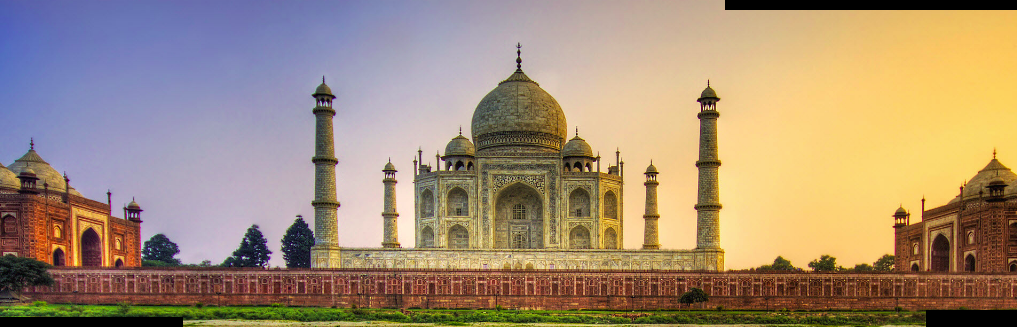

In [0]:
i1 = cv2.imread('img2_1.png')
i2 = cv2.imread('img2_2.png')
i3 = cv2.imread('img2_3.png')

i4 = panorama(i2, i1)
i5 = panorama(i3, i2)
i6 = panorama(i5, i4)
cv2_imshow(i6)

## Eg 2

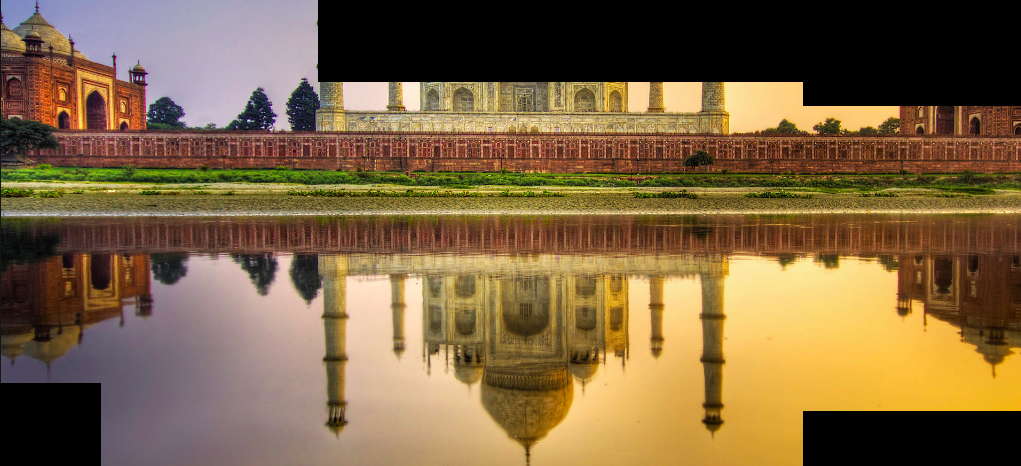

In [0]:
i1 = cv2.imread('img2_4.png')
i2 = cv2.imread('img2_5.png')
i3 = cv2.imread('img2_6.png')

i4 = panorama(i2, i1)
i5 = panorama(i3, i2)
i6 = panorama(i5, i4)
cv2_imshow(i6)

## Eg 3

In [0]:
def trim(frame):
          #crop top
          if not np.sum(frame[0]):
              return trim(frame[1:])
          #crop bottom
          if not np.sum(frame[-1]):
              return trim(frame[:-2])
          #crop left
          if not np.sum(frame[:,0]):
              return trim(frame[:,1:])
          #crop right
          if not np.sum(frame[:,-1]):
              return trim(frame[:,:-2])
          return frame

# def panorama(path_right,path_left):

#       image1=cv2.imread(path_right)
#       image2=cv2.imread(path_left)

def panorama(path_right,path_left):

      image1=path_right
      image2=path_left

      image1_gray=cv2.cvtColor(image1,cv2.COLOR_BGR2GRAY)
      image2_gray=cv2.cvtColor(image2,cv2.COLOR_BGR2GRAY)

      image1=cv2.cvtColor(image1,cv2.COLOR_BGR2RGB)
      image2=cv2.cvtColor(image2,cv2.COLOR_BGR2RGB)

      # Initiate Sift detector
      sift =cv2.xfeatures2d.SIFT_create()
      kp1, des1 = sift.detectAndCompute(image1_gray,None)
      kp2, des2 = sift.detectAndCompute(image2_gray,None)

      # display the keypoints and features detected on both images
      #fig, (ax1,ax2) = plt.subplots(nrows=1, ncols=2, figsize=(20,8), constrained_layout=False)
      #ax1.imshow(cv2.drawKeypoints(image1_gray,kp1,None,color=(0,255,0)))
      #ax1.set_xlabel("(a)", fontsize=14)
      #ax2.imshow(cv2.drawKeypoints(image2_gray,kp2,None,color=(0,255,0)))
      #ax2.set_xlabel("(b)", fontsize=14)

      match = cv2.BFMatcher()
      matches = match.knnMatch(des1,des2,k=2)

      good = []
      for m,n in matches:
          if m.distance < 1.0*n.distance:
              good.append(m)

      draw_params = dict(matchColor=(0,255,0),
                            singlePointColor=None,
                            flags=2)

      img3 = cv2.drawMatches(image1_gray,kp1,image2_gray,kp2,good,None,**draw_params)
      #plt.imshow(img3)

      MIN_MATCH_COUNT = 0
      if len(good) > MIN_MATCH_COUNT:
          src_pts = np.float32([ kp1[m.queryIdx].pt for m in good ]).reshape(-1,1,2)
          dst_pts = np.float32([ kp2[m.trainIdx].pt for m in good ]).reshape(-1,1,2)

          M, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)

          h,w = image2_gray.shape
          pts = np.float32([ [0,0],[0,h-1],[w-1,h-1],[w-1,0] ]).reshape(-1,1,2)
          dst = cv2.perspectiveTransform(pts, M)
          #img2 = cv2.polylines(image2,[np.int32(dst)],True,255,3, cv2.LINE_AA)

          #plt.imshow(img2)
      else:
          print("Not enought matches are found - %d/%d", (len(good)/MIN_MATCH_COUNT), len(good))

      dst = cv2.warpPerspective(image1,M,(image2.shape[1] + image1.shape[1], image2.shape[0]+ image1.shape[0]))
      dst[0:image2.shape[0],0:image2.shape[1]] = image2
      #plt.imshow(dst)

      
      #plt.imshow(trim(dst))
      #cv2.imsave("original_image_stitched_crop.jpg", trim(dst))
      return(trim(dst))

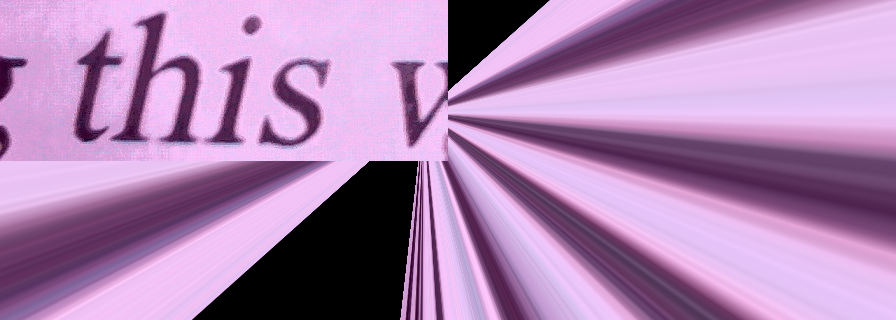

In [0]:
i1 = cv2.imread('img4_1.jpg')
i2 = cv2.imread('img4_2.jpg')

i3 = panorama(i2, i1)
cv2_imshow(i3)

## Hw 1
Panorama was made correctly. This can be because a lot of sift features were present and were correctly matched by knn algorithm.

In [0]:
image1=cv2.imread('IMG-4184.jpg')
image2=cv2.imread('IMG-4183.jpg')

image1_gray=cv2.cvtColor(image1,cv2.COLOR_BGR2GRAY)
image2_gray=cv2.cvtColor(image2,cv2.COLOR_BGR2GRAY)

image1=cv2.cvtColor(image1,cv2.COLOR_BGR2RGB)
image2=cv2.cvtColor(image2,cv2.COLOR_BGR2RGB)

In [40]:
# find the keypoints and descriptors with ORB
kp1, des1 = orb.detectAndCompute(image1_gray,None)
kp2, des2 = orb.detectAndCompute(image2_gray,None)

NameError: ignored

In [0]:
# Initiate Sift detector
sift =cv2.xfeatures2d.SIFT_create()
kp1, des1 = sift.detectAndCompute(image1_gray,None)
kp2, des2 = sift.detectAndCompute(image2_gray,None)

Text(0.5, 0, '(b)')

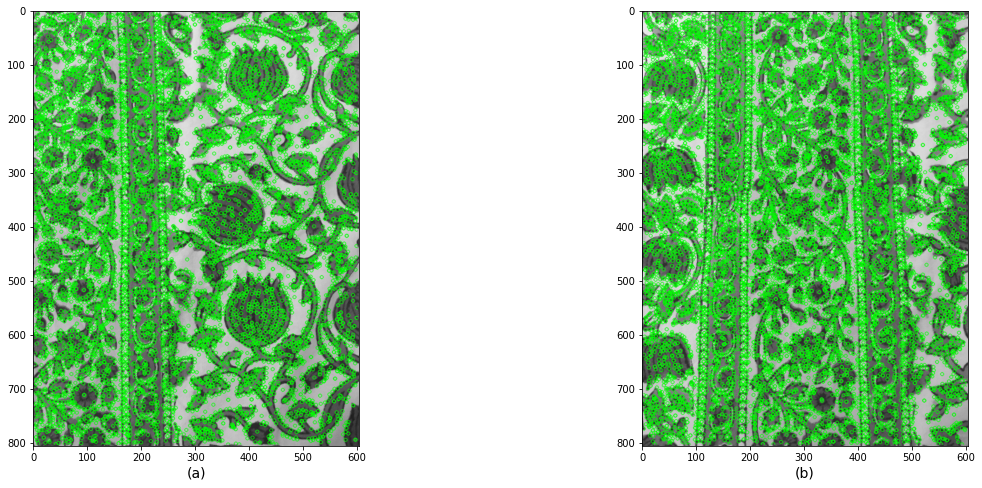

In [68]:
# display the keypoints and features detected on both images
fig, (ax1,ax2) = plt.subplots(nrows=1, ncols=2, figsize=(20,8), constrained_layout=False)
ax1.imshow(cv2.drawKeypoints(image1_gray,kp1,None,color=(0,255,0)))
ax1.set_xlabel("(a)", fontsize=14)
ax2.imshow(cv2.drawKeypoints(image2_gray,kp2,None,color=(0,255,0)))
ax2.set_xlabel("(b)", fontsize=14)

1047


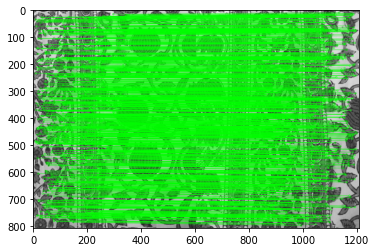

In [69]:
match = cv2.BFMatcher()
matches = match.knnMatch(des1,des2,k=2)

good = []
for m,n in matches:
    if m.distance < 0.3*n.distance:
        good.append(m)

print(len(good))

draw_params = dict(matchColor=(0,255,0),
                       singlePointColor=None,
                       flags=2)

img3 = cv2.drawMatches(image1_gray,kp1,image2_gray,kp2,good,None,**draw_params)
plt.imshow(img3)

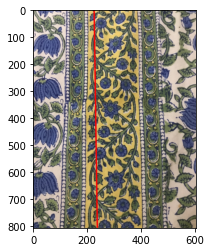

In [70]:
MIN_MATCH_COUNT = 10
if len(good) > MIN_MATCH_COUNT:
    src_pts = np.float32([ kp1[m.queryIdx].pt for m in good ]).reshape(-1,1,2)
    dst_pts = np.float32([ kp2[m.trainIdx].pt for m in good ]).reshape(-1,1,2)

    M, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)

    h,w = image2_gray.shape
    pts = np.float32([ [0,0],[0,h-1],[w-1,h-1],[w-1,0] ]).reshape(-1,1,2)
    dst = cv2.perspectiveTransform(pts, M)
    img2 = cv2.polylines(image2,[np.int32(dst)],True,255,3, cv2.LINE_AA)

    plt.imshow(img2)
else:
    print("Not enought matches are found - %d/%d", (len(good)/MIN_MATCH_COUNT))

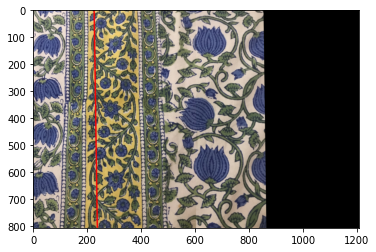

In [71]:
dst = cv2.warpPerspective(image1,M,(image2.shape[1] + image1.shape[1], image2.shape[0]))
dst[0:image2.shape[0],0:image2.shape[1]] = image2
plt.imshow(dst)



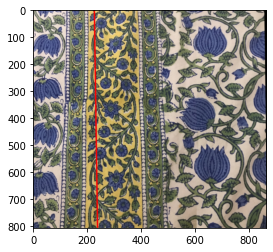

In [72]:
def trim(frame):
    #crop top
    if not np.sum(frame[0]):
        return trim(frame[1:])
    #crop bottom
    if not np.sum(frame[-1]):
        return trim(frame[:-2])
    #crop left
    if not np.sum(frame[:,0]):
        return trim(frame[:,1:])
    #crop right
    if not np.sum(frame[:,-1]):
        return trim(frame[:,:-2])
    return frame

plt.imshow(trim(dst))
#cv2.imsave("original_image_stitched_crop.jpg", trim(dst))

## Hw 2
Could not form correct panorama. Could get many features from sift but couldn't match any of them with each other. This may be because all features are very alike and hence hard to distinguish.

In [0]:
image1=cv2.imread('IMG-4180.jpg')
image2=cv2.imread('IMG-4179.jpg')

image1_gray=cv2.cvtColor(image1,cv2.COLOR_BGR2GRAY)
image2_gray=cv2.cvtColor(image2,cv2.COLOR_BGR2GRAY)

image1=cv2.cvtColor(image1,cv2.COLOR_BGR2RGB)
image2=cv2.cvtColor(image2,cv2.COLOR_BGR2RGB)

In [0]:
# find the keypoints and descriptors with ORB
kp1, des1 = orb.detectAndCompute(image1_gray,None)
kp2, des2 = orb.detectAndCompute(image2_gray,None)

NameError: ignored

In [0]:
# Initiate Sift detector
sift =cv2.xfeatures2d.SIFT_create()
kp1, des1 = sift.detectAndCompute(image1_gray,None)
kp2, des2 = sift.detectAndCompute(image2_gray,None)

Text(0.5, 0, '(b)')

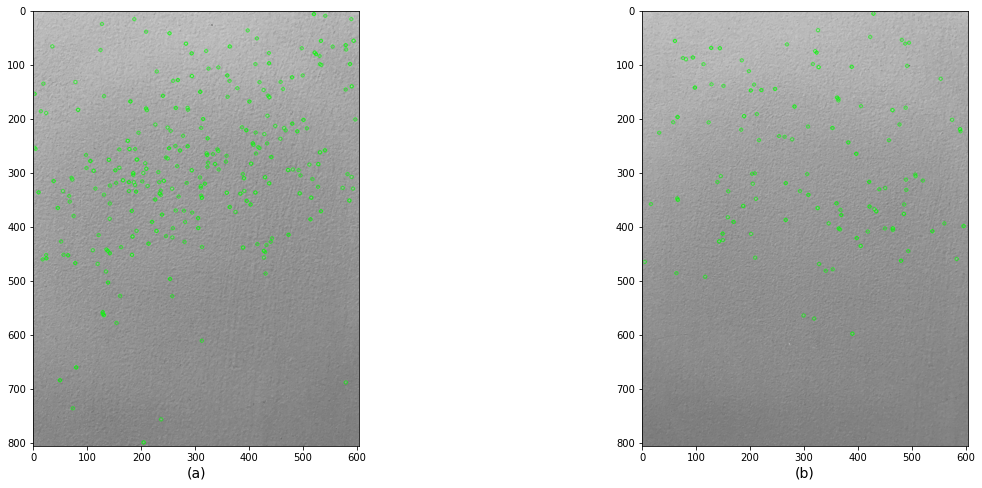

In [101]:
# display the keypoints and features detected on both images
fig, (ax1,ax2) = plt.subplots(nrows=1, ncols=2, figsize=(20,8), constrained_layout=False)
ax1.imshow(cv2.drawKeypoints(image1_gray,kp1,None,color=(0,255,0)))
ax1.set_xlabel("(a)", fontsize=14)
ax2.imshow(cv2.drawKeypoints(image2_gray,kp2,None,color=(0,255,0)))
ax2.set_xlabel("(b)", fontsize=14)

374


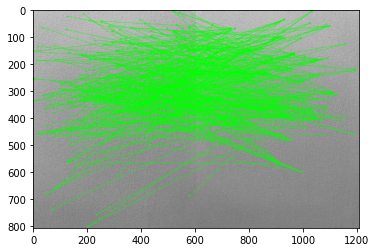

In [102]:
match = cv2.BFMatcher()
matches = match.knnMatch(des1,des2,k=2)

good = []
for m,n in matches:
    if m.distance < n.distance:
        good.append(m)

print(len(good))

draw_params = dict(matchColor=(0,255,0),
                       singlePointColor=None,
                       flags=2)

img3 = cv2.drawMatches(image1_gray,kp1,image2_gray,kp2,good,None,**draw_params)
plt.imshow(img3)

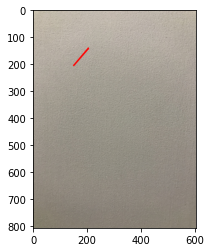

In [103]:
MIN_MATCH_COUNT = 10
if len(good) > MIN_MATCH_COUNT:
    src_pts = np.float32([ kp1[m.queryIdx].pt for m in good ]).reshape(-1,1,2)
    dst_pts = np.float32([ kp2[m.trainIdx].pt for m in good ]).reshape(-1,1,2)

    M, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)

    h,w = image2_gray.shape
    pts = np.float32([ [0,0],[0,h-1],[w-1,h-1],[w-1,0] ]).reshape(-1,1,2)
    dst = cv2.perspectiveTransform(pts, M)
    img2 = cv2.polylines(image2,[np.int32(dst)],True,255,3, cv2.LINE_AA)

    plt.imshow(img2)
else:
    print("Not enought matches are found - %d/%d", (len(good)/MIN_MATCH_COUNT))

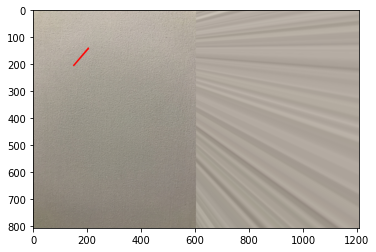

In [104]:
dst = cv2.warpPerspective(image1,M,(image2.shape[1] + image1.shape[1], image2.shape[0]))
dst[0:image2.shape[0],0:image2.shape[1]] = image2
plt.imshow(dst)



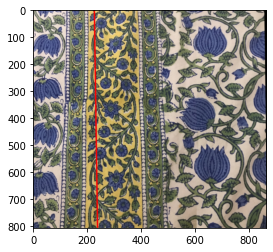

In [0]:
def trim(frame):
    #crop top
    if not np.sum(frame[0]):
        return trim(frame[1:])
    #crop bottom
    if not np.sum(frame[-1]):
        return trim(frame[:-2])
    #crop left
    if not np.sum(frame[:,0]):
        return trim(frame[:,1:])
    #crop right
    if not np.sum(frame[:,-1]):
        return trim(frame[:,:-2])
    return frame

plt.imshow(trim(dst))
#cv2.imsave("original_image_stitched_crop.jpg", trim(dst))

## Hw 3
Could not form panorama. Sift couldn't find a lot of features. This is because the light source made some portion of the image of constant(full white)/smooth value providing not corner points. Also the rest of image was wall so not much features could be found. 

In [0]:
image1=cv2.imread('IMG-4185.jpg')
image2=cv2.imread('IMG-4186.jpg')

image1_gray=cv2.cvtColor(image1,cv2.COLOR_BGR2GRAY)
image2_gray=cv2.cvtColor(image2,cv2.COLOR_BGR2GRAY)

image1=cv2.cvtColor(image1,cv2.COLOR_BGR2RGB)
image2=cv2.cvtColor(image2,cv2.COLOR_BGR2RGB)

In [0]:
# find the keypoints and descriptors with ORB
kp1, des1 = orb.detectAndCompute(image1_gray,None)
kp2, des2 = orb.detectAndCompute(image2_gray,None)

NameError: ignored

In [0]:
# Initiate Sift detector
sift =cv2.xfeatures2d.SIFT_create()
kp1, des1 = sift.detectAndCompute(image1_gray,None)
kp2, des2 = sift.detectAndCompute(image2_gray,None)

Text(0.5, 0, '(b)')

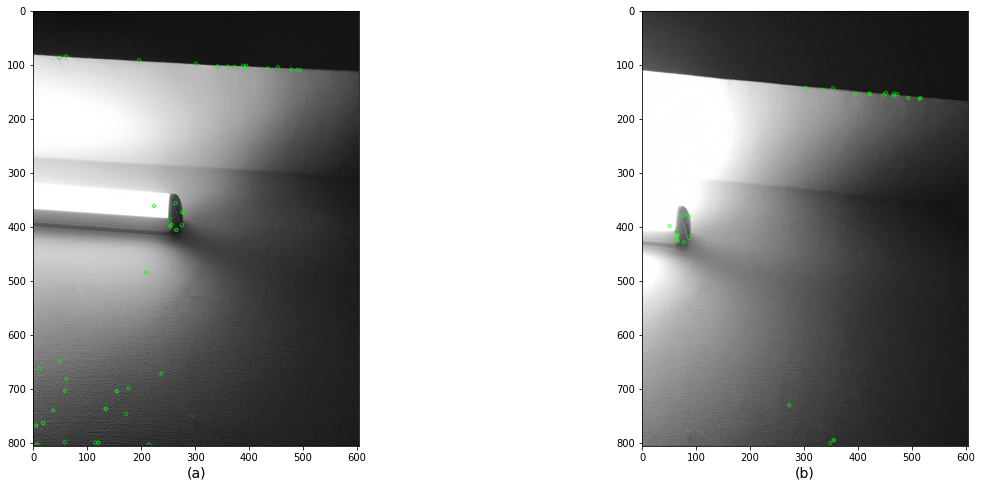

In [87]:
# display the keypoints and features detected on both images
fig, (ax1,ax2) = plt.subplots(nrows=1, ncols=2, figsize=(20,8), constrained_layout=False)
ax1.imshow(cv2.drawKeypoints(image1_gray,kp1,None,color=(0,255,0)))
ax1.set_xlabel("(a)", fontsize=14)
ax2.imshow(cv2.drawKeypoints(image2_gray,kp2,None,color=(0,255,0)))
ax2.set_xlabel("(b)", fontsize=14)

0


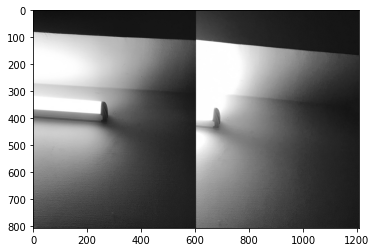

In [88]:
match = cv2.BFMatcher()
matches = match.knnMatch(des1,des2,k=2)

good = []
for m,n in matches:
    if m.distance < 0.3*n.distance:
        good.append(m)

print(len(good))

draw_params = dict(matchColor=(0,255,0),
                       singlePointColor=None,
                       flags=2)

img3 = cv2.drawMatches(image1_gray,kp1,image2_gray,kp2,good,None,**draw_params)
plt.imshow(img3)

In [89]:
MIN_MATCH_COUNT = 10
if len(good) > MIN_MATCH_COUNT:
    src_pts = np.float32([ kp1[m.queryIdx].pt for m in good ]).reshape(-1,1,2)
    dst_pts = np.float32([ kp2[m.trainIdx].pt for m in good ]).reshape(-1,1,2)

    M, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)

    h,w = image2_gray.shape
    pts = np.float32([ [0,0],[0,h-1],[w-1,h-1],[w-1,0] ]).reshape(-1,1,2)
    dst = cv2.perspectiveTransform(pts, M)
    img2 = cv2.polylines(image2,[np.int32(dst)],True,255,3, cv2.LINE_AA)

    plt.imshow(img2)
else:
    print("Not enought matches are found - %d/%d", (len(good)/MIN_MATCH_COUNT))

Not enought matches are found - %d/%d 0.0


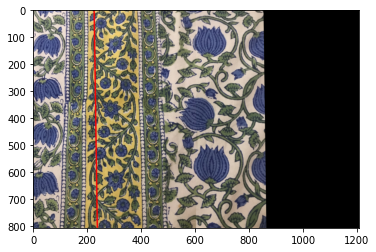

In [0]:
dst = cv2.warpPerspective(image1,M,(image2.shape[1] + image1.shape[1], image2.shape[0]))
dst[0:image2.shape[0],0:image2.shape[1]] = image2
plt.imshow(dst)



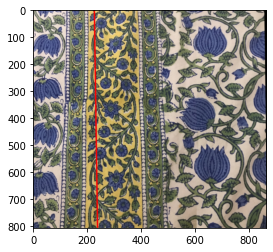

In [0]:
def trim(frame):
    #crop top
    if not np.sum(frame[0]):
        return trim(frame[1:])
    #crop bottom
    if not np.sum(frame[-1]):
        return trim(frame[:-2])
    #crop left
    if not np.sum(frame[:,0]):
        return trim(frame[:,1:])
    #crop right
    if not np.sum(frame[:,-1]):
        return trim(frame[:,:-2])
    return frame

plt.imshow(trim(dst))
#cv2.imsave("original_image_stitched_crop.jpg", trim(dst))

## Hw 4
Could not form panorama. This was because sift couldn't detect many key points which may be due to dark and hence not clear image. Finally knn couldn't give many matches.

In [0]:
i1 = cv2.imread('IMG-4176.jpg')
i2 = cv2.imread('IMG-4175.jpg')

i3 = panorama(i2, i1)
cv2_imshow(i3)

Not enought matches are found - %d/%d 0.0


UnboundLocalError: ignored